In [98]:
from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot
import scipy
from open_atmos_jupyter_utils import show_plot
import networkx as nx

In [99]:
X0 = 4/3 * np.pi * 30.531e-6**3
DV = 1e6 #m3
N0 = 2**23 

PARAMS_P = SimpleNamespace(
    n_part=2**8,
    norm=N0 * DV,
    dist=scipy.stats.expon(loc=0, scale=X0),
)

PARAMS_T = SimpleNamespace(
    span = 300,
    n_step = 2,
    b = 1500, #1/s
    dv = DV
    
)

PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step

RNG = np.random.default_rng(seed=44)

In [100]:
def sample(*, params_p, rng):
    """ samples a particle population specified onto a grid and returns
    a collection indexed by sampling type, with values composed of `size` and `mult`
    real- and integer-valued arrays, respectively """
    u01 = rng.uniform(0, 1, size=params_p.n_part)
    x_range = params_p.dist.ppf(.0001), params_p.dist.ppf(.9999)
    uniform_x = x_range[0] + u01 * (x_range[1] - x_range[0])
    uniform_ln_x = np.exp(np.log(x_range[0]) + u01 * (np.log(x_range[1]) - np.log(x_range[0])))
    return {
        k: {
            'size': v['x'],
            'mult': np.round(v['y'] * params_p.norm).astype(int),
        }
        for k,v in
        {
            'sampling: uniform random in x': {
                'x': uniform_x,
                'y': params_p.dist.pdf(uniform_x) * (x_range[1] - x_range[0]) / params_p.n_part,
            },
            'sampling: uniform random in ln(x)': {
                'x': uniform_ln_x,
                'y': params_p.dist.pdf(uniform_ln_x) * (np.log(x_range[1]) - np.log(x_range[0])) / params_p.n_part * uniform_ln_x,
            },
            'sampling: constant multiplicity': {
                'x': params_p.dist.ppf(u01),
                'y': np.full(shape=params_p.n_part, fill_value=1 / params_p.n_part),
            }
        }.items()
    }

PARTICLES = sample(params_p=PARAMS_P, rng=RNG)

In [101]:
B = {}
for k in PARTICLES.keys():
    B[k] = nx.DiGraph() #should it be a MultiDiGraph?
    for i in range(PARAMS_P.n_part):
        B[k].add_node(i, size_i=PARTICLES[k]['size'][i], mult_i=PARTICLES[k]['mult'][i])

B['sampling: uniform random in x'].nodes[1]

{'size_i': 2.834072362513646e-13, 'mult_i': 28005051715}

In [102]:
def analytic_solution(x, t):
    """ for exponential initial condition """
    print(t)
    tau = 1 - np.exp(-N0 * PARAMS_T.b * X0 * t)
    sqrt_tau = np.sqrt(tau)
    result = (
        (1 - tau)
        * 1
        / (x * np.sqrt(tau))
        * scipy.special.ive(1, 2 * x / X0 * sqrt_tau)
        * np.exp(-(1 + tau - 2 * sqrt_tau) * x / X0)
    )
    return result


1e-10


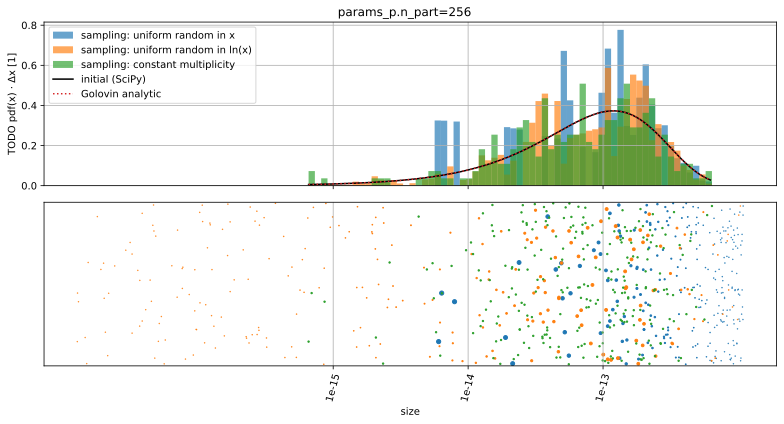

In [103]:
def plot(*, particles, params_p, params_t,rng, title='', time=0):
    """ plots the particle state as both a histogram as well as population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    _, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(11, 6),
        sharex=True,
        tight_layout=True,
    )
    u01 = rng.uniform(0, 1, params_p.n_part)
    scale = params_p.norm / params_p.n_part
    sampled_sizes = particles['sampling: constant multiplicity']['size']
    for k in particles:
        axs['hist'].hist(
            x=np.log(particles[k]['size']),
            weights=particles[k]['mult'] / (params_p.norm),
            bins=64, # TODO!
            range=(np.log(min(sampled_sizes)), np.log(max(sampled_sizes))),
            label=f'{k}',
            alpha=.666,
            density=True,
        )
        axs['part'].scatter(
            np.log(particles[k]['size']),
            u01,
            s=.25 + 2 * particles[k]['mult']/ scale
        )
    log_spaced_m = np.logspace(np.log(min(sampled_sizes)), np.log(max(sampled_sizes)), 256, base=np.e)
    pdf_y = params_p.dist.pdf(log_spaced_m[:-1])
    dm = np.diff(log_spaced_m)
    dlogm = np.diff(np.log(log_spaced_m))   

    axs['hist'].plot(np.log(log_spaced_m[:-1]), dm / dlogm * pdf_y , color='black', label='initial (SciPy)')
    axs['hist'].plot(np.log(log_spaced_m[:-1]), dm / dlogm * analytic_solution(log_spaced_m[:-1], t=time), label='Golovin analytic', ls=":")
    
    axs['hist'].legend()
    axs['hist'].set_ylabel('TODO pdf(x) ⋅ Δx [1]')
    axs['hist'].set_title(title or f'{params_p.n_part=}   ')
    m_ticks = np.array([1e-15, 1e-14, 1e-13])
    axs['part'].set_xticks(np.log(m_ticks), m_ticks)
    axs['part'].xaxis.set_tick_params(rotation=75)
    axs['part'].set_xlabel('size')
    axs['part'].set_yticks([])
    axs['part'].set_ylim(0,1)
    for axes in axs.values():
        axes.grid()
    show_plot()

plot(particles=PARTICLES, params_p=PARAMS_P,params_t = PARAMS_T, rng=RNG, time=1e-10)

**2. Monte-Carlo representation of coagulation dynamics**

In [104]:
count_collisions = {}
count_cloud_scavenging = {}
count_scavenging = {}
for k in PARTICLES.keys():
    count_collisions[k] = 0.
    count_cloud_scavenging[k] = 0.
    count_scavenging[k] = 0.

def coagulate(*, params_p, params_t, particles, rng,graphs):
    """ performs Monte-Carlo coagulation of the particles using a simplified SDM algorithm for an additive kernel """
    n_pairs = params_p.n_part // 2
    p_scale = params_p.n_part * (params_p.n_part - 1) / 2 / n_pairs
    for _ in range(params_t.n_step):        
        non_overlapping_pairs = rng.permutation(params_p.n_part)[: 2 * n_pairs].reshape(-1, 2)
        u01 = rng.uniform(0, 1, n_pairs)
        for samp,part in particles.items():
            for alpha, pair in enumerate(non_overlapping_pairs):
                j, k = pair
                if part['mult'][j] < part['mult'][k]:
                    j, k = k, j
                kern = params_t.b * (part['size'][j] + part['size'][k])
                prob = part['mult'][j] * kern * params_t.step / params_t.dv

                gamma = np.ceil(prob * p_scale - u01[alpha])
                if gamma != 0:
                    gamma_t = min(gamma, part['mult'][j] // part['mult'][k])
                    deficit = (gamma - gamma_t) * part['mult'][k]
                    if deficit > 0:
                        print("DEFICIT!",deficit)
                    del(gamma)
                    count_collisions[samp] += 1.
                    # create edge in graph from j to k with weight gamma
                    graphs[samp].add_edge(j, k, mult_transfer = gamma_t*part['mult'][k],
                                          total_mass_transfer = gamma_t*part['size'][j]*part['mult'][k],
                                          size_transfer = part['size'][j],
                                          total_mass_deficit=deficit*part['size'][j],
                                          size_deficit=deficit*part['size'][j] /part['mult'][k],
                                          mult_deficit=deficit)

                    if min(part['size'][j], part['size'][k]) < 4e-14:
                        count_scavenging[samp] +=1
                        if max(part['size'][j], part['size'][k]) > 5.2e-13:
                            count_cloud_scavenging[samp] += 1.

                    if part['mult'][j] > gamma_t * part['mult'][k]: 
                        part['mult'][j] -= gamma_t * part['mult'][k]
                        part['size'][k] += gamma_t * part['size'][j] 
                    else:
                        part['mult'][j] = part['mult'][k] // 2
                            # assert part['mult'][j] != 0
                        part['mult'][k] -= part['mult'][k] // 2
                        part['size'][k] += gamma_t * part['size'][j]
                        part['size'][j] = part['size'][k]

coagulate(particles=PARTICLES, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG, graphs = B)


DEFICIT! 94113886700.0
DEFICIT! 27368155832.0
DEFICIT! 46343706989.0
DEFICIT! 23615058615.0
DEFICIT! 36352831687.0
DEFICIT! 57036801891.0
DEFICIT! 45321414848.0
DEFICIT! 18675820444.0
DEFICIT! 108567810784.0
DEFICIT! 261232579704.0
DEFICIT! 131847503816.0
DEFICIT! 196582432556.0
DEFICIT! 32768000000.0
DEFICIT! 27374236428.0
DEFICIT! 24912184101.0
DEFICIT! 114073603782.0
DEFICIT! 38011051538.0
DEFICIT! 191476960584.0
DEFICIT! 36082764691.0
DEFICIT! 244107381076.0
DEFICIT! 35064713628.0
DEFICIT! 242863631187.0


In [105]:
# count_collisions
# count_cloud_scavenging
count_scavenging

{'sampling: uniform random in x': 14.0,
 'sampling: uniform random in ln(x)': 73.0,
 'sampling: constant multiplicity': 44.0}

In [106]:
# add final size as node attribute
for k in PARTICLES.keys():
    for i in range(PARAMS_P.n_part):
        B[k].nodes[i]['size_f'] = PARTICLES[k]['size'][i]
        B[k].nodes[i]['mult_f'] = PARTICLES[k]['mult'][i]

300


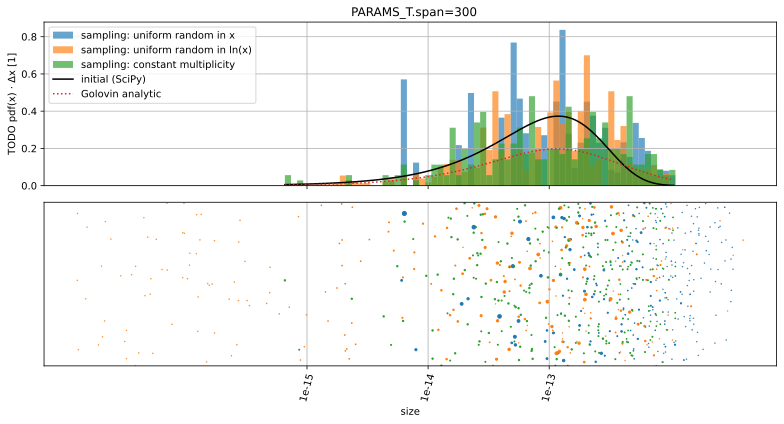

In [ ]:
#TODO:check analytic solution
plot(
    particles=PARTICLES,
    params_p=PARAMS_P,
    params_t=PARAMS_T,
    rng=RNG,
    time=PARAMS_T.span,
    title=f'  {PARAMS_T.span=}'
)

In [109]:
graph_types = ["total_mass","size","mult"]

fig, axs = pyplot.subplot_mosaic(
    [['sampling: uniform random in x' + t for t in graph_types], 
        ['sampling: uniform random in ln(x)' + t for t in graph_types], 
        ['sampling: constant multiplicity' + t for t in graph_types]],
    figsize=(9, 9),
    tight_layout=True,
)
titles = {
        'sampling: uniform random in x': 'uniform-in-r',
        'sampling: uniform random in ln(x)': 'uniform-in-log(r)',
        'sampling: constant multiplicity': 'constant-multiplicity',
        'total_mass': 'Total Mass',
        'mult': 'Multiplicity',
        'size': 'Individual Mass',
}



for k in B:

    pos = nx.forceatlas2_layout(B[k], scaling_ratio=0.2, strong_gravity=True, )

    for graph_type in graph_types:
        ax = axs[k+graph_type]

        if graph_type == "total_mass":
            attr_i = np.array([B[k].nodes[i]['size_i'] * B[k].nodes[i]['mult_i'] for i in B[k].nodes])
            attr_f = np.array([B[k].nodes[i]['size_f'] * B[k].nodes[i]['mult_f']for i in B[k].nodes])
            scale = 1e4
            scale_edge = 1e2
        else:
            attr_i = np.array([B[k].nodes[i][graph_type + "_i"] for i in B[k].nodes])
            attr_f = np.array([B[k].nodes[i][graph_type + "_f"] for i in B[k].nodes])
            scale = 1e14 if graph_type == "size" else 1e-9
            scale_edge = 1e4 if graph_type == "size" else 1e-11



        nx.draw(B[k], pos, ax=ax, 
                node_size= scale * attr_i, 
                # edge width is mass_transfer
                alpha= 0.4,
                width=[0.2 + scale_edge * B[k].edges[e][graph_type +'_transfer'] for e in B[k].edges],
                arrowsize=5,

                with_labels=False
                )
        nx.draw_networkx_edges(B[k],pos=pos,ax=ax,
                edgelist=[e for e in B[k].edges if B[k].edges[e]['mult_deficit']>0],
                edge_color='red',
                width=[0.2 + 1e-11 * B[k].edges[e]['mult_transfer'] for e in B[k].edges if B[k].edges[e]['mult_deficit']>0],
                label='deficit',
                #     arrowstyle="->",
                arrowsize=5,
                )
        nx.draw_networkx_nodes(B[k], pos, ax=ax, 
                node_size= scale * attr_f, #* B[k].nodes[i]['size_f'] * 
                node_color='purple',
                alpha=0.3,
                label='final size'
                )
        if k == 'sampling: uniform random in x':
            ax.set_title(titles[graph_type], fontsize=12)

        if graph_type == "total_mass":
            ax.annotate(titles[k], xy=(-0.15, 0.5), xycoords='axes fraction', va='center', 
                        fontsize=12,
                        rotation=90)

pyplot.savefig('sdm_network.pdf')
